In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Code Testing
---

## 1.1) Coupled Spring Masses
---

### 1.1.1) Simulation Results

In [27]:
%%bash
fname_res="../results/sim_spring_res.txt"

mass_building=10.0
mass_dampner=0.3

k_building=8.0
k_dampner=3.0

fr_building=0.2
fr_dampner=0.8

run_time=20.0

g++ -O3 -o sim_spring.exe ../src/sim_spring.cpp

./sim_spring.exe $fname_res $mass_building $mass_dampner $run_time

rm sim_spring.exe

Text(0, 0.5, 'Mass Position [m]')

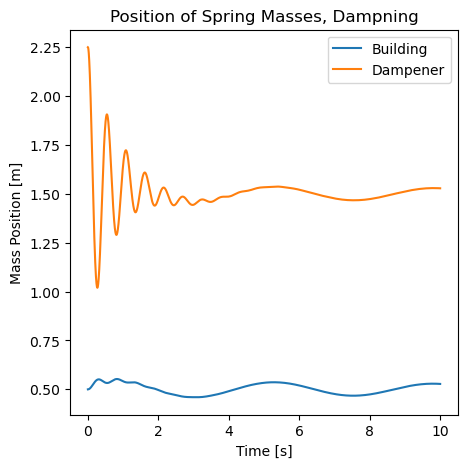

In [28]:
data_tmd = np.genfromtxt('../results/sim_spring_res.txt', dtype='f8', delimiter=',', usecols=[0,1,2,3])

data_range = np.linspace(0,10, len(data_tmd[:,0]))

fig, ax1 = plt.subplots()
fig.set_size_inches(5,5)

ax1.plot(data_range, data_tmd[:,0], label='Building')
ax1.plot(data_range, data_tmd[:,2], label='Dampener')

ax1.legend()

ax1.set_title('Position of Spring Masses, Dampning')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Mass Position [m]')

## 1.2) Optimization Results

In [30]:
%%bash
fname_init_conds="../init_conds/optim_test.txt"
fname_seis_data="../init_conds/elcentro_NS.dat.txt"
fname_res="../results/sim_build_res.txt"

g++ -O3 -o sim_building.exe ../src/sim_building.cpp

./sim_building.exe $fname_init_conds $fname_seis_data $fname_res

rm sim_building.exe

In [ ]:
quake_date = np.genfromtxt('../init_conds/elcentro_NS.dat.txt', delimiter=' ', usecols=(0,1), dtype='f8')
data_damp = np.genfromtxt('../results/sim_build_res.txt', delimiter=',', skip_header=1, usecols=(0,1,2,3,4,5), dtype='f8')
data_no_damp = np.genfromtxt('../results/sim_build_res.txt', delimiter=',', skip_header=1, usecols=(0,1,2,3,4,5), dtype='f8')